In [14]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def remove_hair(images, cfg=None):
    num_images = len(images)
    if cfg is None:
        class CFG:
            def __init__(self):
                self.edge_low_threshold = 100
                self.edge_high_threshold = 220
                self.dark_spot_threshold = 150
                self.linelength_threshold = 10
                self.divergence_threshold = 0.25
                self.patchiness_threshold = 0.15
                self.interp_win = 20
        cfg = CFG()

    # --- make ax always 2D to avoid IndexError when only one image ---
    fig, ax = plt.subplots(num_images, 6, figsize=(12, 2 * num_images))
    if num_images == 1:
        ax = np.expand_dims(ax, axis=0)
    plt.subplots_adjust(wspace=0.01, hspace=0.2)
    for this_ax in ax.ravel():
        this_ax.set_axis_off()

    last_filtered = None  # will hold the last processed image

    for image_ind, img_orig in enumerate(images):
        image_size = img_orig.shape[:2]
        plt.sca(ax[image_ind, 0])

        # --- Handle grayscale vs RGB ---
        if img_orig.ndim == 3:
            RGB_input = 1
            img = img_orig.mean(-1)
        else:
            RGB_input = 0
            img = img_orig.copy()
        plt.imshow(img_orig, cmap='gray')
        plt.title('Original')

        skip_flag = 0

        # --- BlackHat morphological filter ---
        plt.sca(ax[image_ind, 1])
        kernel = np.ones((3,3),np.uint8)
        img_filt = cv.morphologyEx(np.uint8(img), cv.MORPH_BLACKHAT, kernel) 
        img_filt = np.where(img_filt > 15, img_filt, 0)
        kernel = np.ones((4,4),np.uint8)
        img_filt = cv.morphologyEx(img_filt, cv.MORPH_DILATE, kernel)
        plt.imshow(img_filt, cmap='gray')
        plt.title('BlackHat')

        # --- Mask only dark pixels ---
        plt.sca(ax[image_ind, 2])
        dark_spots = (img < cfg.dark_spot_threshold).astype(np.uint8)
        kernel = np.ones((4,4),np.uint8)
        dark_spots = cv.morphologyEx(dark_spots, cv.MORPH_DILATE, kernel)
        img_filt = img_filt * dark_spots
        plt.imshow(img_filt, cmap='gray')
        plt.title('Only darker pixels')

        # --- Detect lines ---
        plt.sca(ax[image_ind, 3])
        lines = cv.HoughLinesP(img_filt, cv.HOUGH_PROBABILISTIC, np.pi / 90, 20, None, 1, 20)

        if lines is not None:
            lines = lines.reshape(-1, 4)
            N_lines = lines.shape[0]
            lines_to_interp = []
            for ind in range(N_lines):
                line = lines[ind, :]
                x, y = fill_line(line[0::2], line[1::2], 1)
                line_length = np.sqrt((line[0] - line[2])**2 + (line[1] - line[3])**2)
                if line_length < cfg.linelength_threshold:
                    plt.scatter(x, y, 30, alpha=0.1, c='green')
                else:
                    plt.scatter(x, y, 1, alpha=0.5, c='red')
                    lines_to_interp.append((x, y))
        else:
            skip_flag = 1
            img_filt = np.zeros(image_size)
        plt.imshow(img_filt, cmap='gray')
        plt.title('Long lines')

        # --- Build mask ---
        plt.sca(ax[image_ind, 4])
        if skip_flag == 1:
            Mask = np.zeros(image_size)
        else:
            Mask = np.zeros_like(img_filt)
            for (x, y) in lines_to_interp:
                Mask[y, x] = 1
            kernel = np.ones((3,3),np.uint8)
            Mask = cv.morphologyEx(Mask, cv.MORPH_DILATE, kernel)
            Mask = Mask.astype(float)
            Mask_i_inds, Mask_j_inds = np.where(Mask)

            i, j = np.where(Mask != 0)
            if i.size == 0:
                skip_flag = 1
                Mask = np.zeros(image_size)
            else:
                x_patchinees = np.std(j) / Mask.shape[1]
                y_patchinees = np.std(i) / Mask.shape[0]
                x_divergence = np.abs(0.5 - np.mean(i) / Mask.shape[0])
                y_divergence = np.abs(0.5 - np.mean(j) / Mask.shape[1])
                patchiness = np.sqrt(x_patchinees * y_patchinees)
                divergence = np.max([x_divergence, y_divergence])
                if (divergence < cfg.divergence_threshold) and (patchiness < cfg.patchiness_threshold):
                    skip_flag = 1
                    Mask = np.zeros(image_size)
        plt.imshow(Mask, cmap='gray')
        plt.title('Final mask')

        # --- Interpolate hair region ---
        plt.sca(ax[image_ind, 5])
        if skip_flag:
            img_filtered = img_orig
        else:
            Mask_temp = 1 - 2 * Mask
            img_filtered = img_orig.copy()
            if RGB_input:
                for channel in range(img_orig.shape[-1]):
                    img_masked = np.squeeze(img_orig[:,:,channel]) * Mask_temp
                    img_filtered[:, :, channel] = fill_image(img_masked, Mask_i_inds, Mask_j_inds, interp_win=cfg.interp_win)
            else:
                img_masked = img_orig * Mask_temp
                img_filtered = fill_image(img_masked, Mask_i_inds, Mask_j_inds)

        plt.imshow(img_filtered, cmap='gray')
        plt.title('Filtered')
        last_filtered = img_filtered  # store last image

    return last_filtered


def fill_image(img_masked, i_inds, j_inds, interp_win=10):
    for i, j in zip(i_inds, j_inds):
        if (i>=interp_win) or (j>=interp_win):
            template = img_masked[i: i+2*interp_win, j: j+2*interp_win].flatten()
        elif (img_masked.shape[0] - i < interp_win) or (img_masked.shape[1] - j < interp_win):
            template = img_masked[i-2*interp_win: i, j-2*interp_win: j].flatten()
        else:
            template = img_masked[i-interp_win: i+interp_win, j-interp_win: j+interp_win].flatten()
        template = np.delete(template, (template < 0))
        img_masked[i, j] = np.median(template)
    return img_masked


def fill_line(x, y, step=1):
    if x[0] == x[1]:
        ys = np.arange(y.min(), y.max(), step)
        xs = np.repeat(x[0], ys.size)
    else:
        m = (y[1] - y[0]) / (x[1] - x[0])
        xs = np.arange(x[0], x[1], step * np.sign(x[1]-x[0]))
        ys = y[0] + m * (xs - x[0])
    return xs.astype(int), ys.astype(int)

True

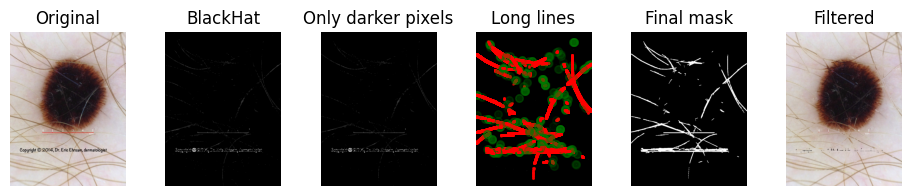

In [15]:
img_path = '/Users/ammaster10/Documents/SIIT/QMUL/SkinLesionDataset/Test/Combined/29.jpg'
import cv2

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

filtered = remove_hair([img])

# Save or reuse later
cv2.imwrite("cleaned_29.jpg", cv2.cvtColor(filtered, cv2.COLOR_RGB2BGR))

In [10]:
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.catch_warnings 

import torchvision

import cv2 as cv

data_path = '/Users/ammaster10/Documents/SIIT/QMUL/SkinLesionDataset/Test'

train_data = torchvision.datasets.ImageFolder(data_path)

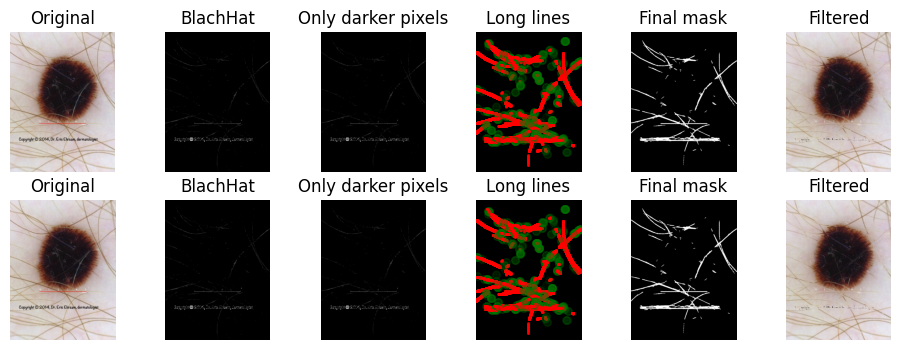

In [13]:
import os
import cv2

data_path = '/Users/ammaster10/Documents/SIIT/QMUL/SkinLesionDataset/Test/Combined'
img_path = os.path.join(data_path, '29.jpg')

# --- Load as RGB NumPy array ---
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Image not found: {img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- Pass to your function ---
images = [img,img]
images_no_hair = remove_hair(images)

In [ ]:
images = []
# for i in np.random.choice(len(train_data), size=10, replace=False):
#     img = np.array(train_data[i][0])
#     images.append(img)

train_data.select(img ="29.jpg")
img = np.array(train_data[i][0])
images.append(img)
images_no_hair = remove_hair(images)

NameError: name 'train_data' is not defined

In [16]:
import numpy as np
import cv2 as cv

def remove_hair_single(img_orig, cfg=None):
    """
    Removes hair from one dermoscopic image (RGB or grayscale).
    Returns the cleaned image only (no plots).
    Optimized for preprocessing before CNN training.
    """
    if cfg is None:
        class CFG:
            def __init__(self):
                self.edge_low_threshold = 100
                self.edge_high_threshold = 220
                self.dark_spot_threshold = 150
                self.linelength_threshold = 10
                self.divergence_threshold = 0.25
                self.patchiness_threshold = 0.15
                self.interp_win = 20
        cfg = CFG()

    image_size = img_orig.shape[:2]

    # Convert to grayscale if RGB
    if img_orig.ndim == 3:
        RGB_input = True
        img = img_orig.mean(-1)
    else:
        RGB_input = False
        img = img_orig.copy()

    # --- Step 1: BlackHat filter to find hair-like lines ---
    kernel = np.ones((3, 3), np.uint8)
    img_filt = cv.morphologyEx(np.uint8(img), cv.MORPH_BLACKHAT, kernel)
    img_filt = np.where(img_filt > 15, img_filt, 0)
    kernel = np.ones((4, 4), np.uint8)
    img_filt = cv.morphologyEx(img_filt, cv.MORPH_DILATE, kernel)

    # --- Step 2: Mask only dark regions ---
    dark_spots = (img < cfg.dark_spot_threshold).astype(np.uint8)
    kernel = np.ones((4, 4), np.uint8)
    dark_spots = cv.morphologyEx(dark_spots, cv.MORPH_DILATE, kernel)
    img_filt = img_filt * dark_spots

    # --- Step 3: Detect line candidates ---
    lines = cv.HoughLinesP(img_filt, cv.HOUGH_PROBABILISTIC, np.pi / 90, 20, None, 1, 20)

    # --- Step 4: Create mask ---
    Mask = np.zeros(image_size, dtype=np.uint8)
    if lines is not None:
        for line in lines.reshape(-1, 4):
            x1, y1, x2, y2 = line
            cv.line(Mask, (x1, y1), (x2, y2), 255, 1)
        Mask = cv.dilate(Mask, np.ones((3, 3), np.uint8), iterations=1)

    # --- Step 5: Inpaint to remove hairs ---
    img_filtered = cv.inpaint(
        img_orig.astype(np.uint8),
        Mask,
        inpaintRadius=3,
        flags=cv.INPAINT_TELEA
    )

    return img_filtered

In [19]:
img_path = '/Users/ammaster10/Documents/SIIT/QMUL/SkinLesionDataset/Test/Combined/29.jpg'
import cv2

# img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

import cv2, numpy as np
from pathlib import Path

img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
cleaned = remove_hair_single(img)
cv2.imwrite("example_cleaned.jpg", cv2.cvtColor(cleaned, cv2.COLOR_RGB2BGR))

True

In [20]:
!pip install -q opencv-python-headless==4.10.0.84 numpy pillow matplotlib

In [ ]:
import cv2 as cv, numpy as np, matplotlib.pyplot as plt
from google.colab import files
from pathlib import Path

def shade_of_gray_cc(img, power=6, gamma=None, eps=1e-6):
    img = img.astype(np.float32)
    if gamma is not None:
        img = np.power(np.clip(img/255., 1e-6, 1), 1.0/gamma) * 255.
    mean_per_c = np.power(np.mean(np.power(img, power), axis=(0,1)) + eps, 1/power)
    scale = np.sqrt(3) / (np.linalg.norm(mean_per_c) + eps) * mean_per_c
    img = img / (scale + eps)
    return np.clip(img, 0, 255).astype(np.uint8)

def detect_hair_mask_v1(bgr, kernel_px=17, thr_percentile=92, handle_light=False):
    gray = cv.cvtColor(shade_of_gray_cc(bgr, power=6, gamma=None), cv.COLOR_BGR2GRAY)
    se = cv.getStructuringElement(cv.MORPH_RECT, (kernel_px, kernel_px))
    blackhat = cv.morphologyEx(gray, cv.MORPH_BLACKHAT, se)
    thr = np.percentile(blackhat, thr_percentile)
    hair_dark = (blackhat > thr).astype(np.uint8) * 255
    if handle_light:
        inv = 255 - gray
        tophat = cv.morphologyEx(inv, cv.MORPH_TOPHAT, se)
        thr2 = np.percentile(tophat, thr_percentile)
        hair_light = (tophat > thr2).astype(np.uint8) * 255
        hair = cv.bitwise_or(hair_dark, hair_light)
    else:
        hair = hair_dark
    hair = cv.morphologyEx(hair, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT,(3,3)))
    hair = cv.dilate(hair, cv.getStructuringElement(cv.MORPH_RECT,(3,3)), 1)
    return hair

def pad_resize(bgr, size=512):
    h, w = bgr.shape[:2]
    scale = min(size / h, size / w)
    nh, nw = int(round(h*scale)), int(round(w*scale))
    interp = cv.INTER_AREA if scale < 1 else cv.INTER_CUBIC
    canvas = np.full((size, size, 3), 255, np.uint8)
    rs = cv.resize(bgr, (nw, nh), interpolation=interp)
    y0 = (size - nh)//2; x0 = (size - nw)//2
    canvas[y0:y0+nh, x0:x0+nw] = rs
    return canvas

def overlay_mask_on_image(bgr, mask, alpha=0.55):
    red = np.zeros_like(bgr); red[...,2] = 255
    m = (mask>0).astype(np.uint8)[...,None]
    return cv.addWeighted((m*red + (1-m)*bgr).astype(np.uint8), alpha, bgr, 1-alpha, 0)

def _soft_edge_alpha(mask, feather_px=2):
    m = (mask>0).astype(np.uint8)
    if m.max()==0: return m.astype(np.float32)
    di = cv.distanceTransform(m, cv.DIST_L2, 3)
    do = cv.distanceTransform(1-m, cv.DIST_L2, 3)
    a = di / (di + do + 1e-6)  # 0 at edge → 1 inside fill
    if feather_px>0:
        a = cv.GaussianBlur(a, (2*feather_px+1, 2*feather_px+1), 0)
    return np.clip(a,0,1).astype(np.float32)

def _ignore_watermark(mask, frac=0.12):
    H,W = mask.shape
    out = mask.copy()
    out[int((1-frac)*H):,:] = 0
    return out

def _protect_dark_core(mask, bgr, p=20):
    lab = cv.cvtColor(bgr, cv.COLOR_BGR2LAB); L = lab[:,:,0]
    Lb = cv.GaussianBlur(L, (0,0), 3)
    _, th = cv.threshold(255-Lb, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    th = cv.morphologyEx(th, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE,(9,9)), 2)
    th = cv.morphologyEx(th, cv.MORPH_OPEN,  cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5)), 1)
    num, labmap, stats, _ = cv.connectedComponentsWithStats(th, 8)
    if num<=1: return mask
    idx = 1 + np.argmax(stats[1:, cv.CC_STAT_AREA])
    lesion = (labmap==idx).astype(np.uint8)
    vals = L[lesion>0]
    if vals.size<50: return mask
    t = np.percentile(vals, p)
    core = np.zeros_like(L, np.uint8); core[(L<=t)&(lesion>0)] = 255
    core = cv.dilate(core, cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)), 1)
    return cv.bitwise_and(mask, cv.bitwise_not(core))

def _split_thin_thick(mask, thick_px=5):
    num, labels, stats, _ = cv.connectedComponentsWithStats(mask, 8)
    thin = np.zeros_like(mask); thick = np.zeros_like(mask)
    for i in range(1, num):
        w,h = stats[i][cv.CC_STAT_WIDTH], stats[i][cv.CC_STAT_HEIGHT]
        (thick if min(w,h)>=thick_px else thin)[labels==i] = 255
    return thin, thick

def _masked_guided_smooth(bgr, mask, radius=3, eps=1e-4):
    # Guided filter if available, otherwise bilateral as fallback
    if hasattr(cv, "ximgproc") and hasattr(cv.ximgproc, "guidedFilter"):
        sm = cv.ximgproc.guidedFilter(guide=bgr, src=bgr, radius=radius, eps=eps)
    else:
        sm = cv.bilateralFilter(bgr, d=5, sigmaColor=30, sigmaSpace=7)
    m = (mask>0).astype(np.uint8)[...,None]
    return np.where(m.astype(bool), sm, bgr)

def clahe_outside_mask(bgr, mask, clip=2.0, tiles=(8,8)):
    lab = cv.cvtColor(bgr, cv.COLOR_BGR2LAB); l,a,b = cv.split(lab)
    clahe = cv.createCLAHE(clipLimit=clip, tileGridSize=tiles)
    l2 = clahe.apply(l)
    out = cv.cvtColor(cv.merge([l2,a,b]), cv.COLOR_LAB2BGR)
    m = (mask>0).astype(np.uint8)[...,None]
    return np.where(m.astype(bool), bgr, out)

def smart_replace_v1_two_pass(
    bgr, hair_mask,
    grow_px_thin=1, grow_px_thick=3,
    r_thin=2, r_thick=4,
    ignore_watermark=True, protect_core=True,
    feather_px=2, guided_radius=3
):
    if hair_mask.max()==0: return bgr.copy(), hair_mask

    thin, thick = _split_thin_thick(hair_mask, thick_px=5)

    if grow_px_thin>0:
        thin  = cv.dilate(thin,  cv.getStructuringElement(cv.MORPH_ELLIPSE,(2*grow_px_thin+1,)*2), 1)
    if grow_px_thick>0:
        thick = cv.dilate(thick, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2*grow_px_thick+1,)*2), 1)

    def prep(m):
        if ignore_watermark: m = _ignore_watermark(m, 0.12)
        if protect_core:     m = _protect_dark_core(m, bgr, p=20)
        return m

    thin, thick = prep(thin), prep(thick)

    out1 = cv.inpaint(bgr, thin,  r_thin,  cv.INPAINT_NS)
    out2 = cv.inpaint(out1, thick, r_thick, cv.INPAINT_NS)

    union = cv.bitwise_or(thin, thick)
    # guided smoothing only inside the filled area
    out2  = _masked_guided_smooth(out2, union, radius=guided_radius, eps=1e-4)

    alpha = _soft_edge_alpha(union, feather_px=feather_px)[...,None]
    out = (alpha*out2.astype(np.float32) + (1.0-alpha)*bgr.astype(np.float32)).astype(np.uint8)
    return out, union

def preprocess_single_image_v1_twopass(
    bgr,
    size=512,
    kernel_px=17, thr_percentile=92, handle_light=False,
    r_thin=2, r_thick=4,
    grow_px_thin=1, grow_px_thick=3,
    use_clahe=False  # if True, CLAHE is applied only outside the fill
):
    mask = detect_hair_mask_v1(bgr, kernel_px=kernel_px, thr_percentile=thr_percentile, handle_light=handle_light)
    out, union = smart_replace_v1_two_pass(
        bgr, mask,
        grow_px_thin=grow_px_thin, grow_px_thick=grow_px_thick,
        r_thin=r_thin, r_thick=r_thick,
        ignore_watermark=True, protect_core=True,
        feather_px=2, guided_radius=3
    )
    if use_clahe:
        out = clahe_outside_mask(out, union, clip=2.0, tiles=(8,8))
    out = pad_resize(out, size=size)
    return out, mask, union

def run_upload_v1_twopass(
    size=512, kernel_px=17, thr_percentile=92, handle_light=False,
    r_thin=2, r_thick=4, grow_px_thin=1, grow_px_thick=3,
    use_clahe=False
):
    print("Choose one or more images to upload…")
    uploaded = files.upload()
    out_dir = Path("/content/preprocess_uploads_v1_twopass"); out_dir.mkdir(parents=True, exist_ok=True)
    ex = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}

    for fname, data in uploaded.items():
        p = Path(fname)
        if p.suffix.lower() not in ex: 
            print(f"Skipping {fname}"); continue
        arr = np.frombuffer(data, np.uint8)
        bgr = cv.imdecode(arr, cv.IMREAD_COLOR)
        if bgr is None:
            print(f"Failed to read {fname}"); continue

        out, mask, union = preprocess_single_image_v1_twopass(
            bgr, size=size,
            kernel_px=kernel_px, thr_percentile=thr_percentile, handle_light=handle_light,
            r_thin=r_thin, r_thick=r_thick, grow_px_thin=grow_px_thin, grow_px_thick=grow_px_thick,
            use_clahe=use_clahe
        )

        cv.imwrite(str(out_dir / f"{p.stem}_v1_twopass.png"), out)
        cv.imwrite(str(out_dir / f"{p.stem}_hairmask_v1.png"), mask)
        cv.imwrite(str(out_dir / f"{p.stem}_unionmask.png"), union)

        overlay = overlay_mask_on_image(bgr, mask, alpha=0.55)
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(cv.cvtColor(bgr, cv.COLOR_BGR2RGB));     plt.axis('off'); plt.title("Original")
        plt.subplot(1,3,2); plt.imshow(cv.cvtColor(overlay, cv.COLOR_BGR2RGB));  plt.axis('off'); plt.title("Hair mask (v1)")
        plt.subplot(1,3,3); plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB));      plt.axis('off'); plt.title("Hair removed")
        plt.tight_layout(); plt.show()

    print("Saved to:", out_dir)

run_upload_v1_twopass(
    size=512,
    kernel_px=17, thr_percentile=92, handle_light=False,
    r_thin=2, r_thick=4,         
    grow_px_thin=1, grow_px_thick=3,
    use_clahe=False              
)
